<a href="https://colab.research.google.com/github/yendriferreira/Credit-Card-FraudML/blob/main/Tuning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
# Importación de librerías básicas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style='whitegrid')


In [ ]:
files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)


X = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
y = X.pop('Class')

Files in dataset directory: ['creditcard.csv']


In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, cross_validate,
    train_test_split, StratifiedShuffleSplit
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, make_scorer
)

# Modelos requeridos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Balanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

class FixedFraudDetectionTuning:
    def __init__(self, X, y, random_state=42, fast_mode=True, sample_size=50000):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.fast_mode = fast_mode
        self.sample_size = sample_size

        self.scaler = StandardScaler()
        self.X_scaled = None
        self.X_sample = None
        self.y_sample = None
        self.results = []  # Lista para todos los resultados
        self.best_models = {}  # Solo mejores por modelo

        # Configuracion de validacion cruzada
        if fast_mode:
            self.outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            self.inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)
        else:
            self.outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
            self.inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

        # Metricas
        self.scoring = {
            'auprc': make_scorer(average_precision_score),
            'auc_roc': make_scorer(roc_auc_score),
            'precision': make_scorer(precision_score, zero_division=0),
            'recall': make_scorer(recall_score, zero_division=0),
            'f1': make_scorer(f1_score, zero_division=0)
        }

    def prepare_data(self):
        """Preparar datos con muestreo estratificado opcional"""
        self.X_scaled = self.scaler.fit_transform(self.X)

        # Muestreo estratificado para acelerar tuning
        if self.sample_size and len(self.X_scaled) > self.sample_size:
            print(f"Modo rapido: Usando muestra estratificada de {self.sample_size:,} transacciones")

            # Muestreo estratificado manteniendo proporcion de fraudes
            sss = StratifiedShuffleSplit(n_splits=1, train_size=self.sample_size,
                                       random_state=self.random_state)
            sample_idx, _ = next(sss.split(self.X_scaled, self.y))

            self.X_sample = self.X_scaled[sample_idx]
            self.y_sample = self.y.iloc[sample_idx] if hasattr(self.y, 'iloc') else self.y[sample_idx]
        else:
            self.X_sample = self.X_scaled
            self.y_sample = self.y

        print(f"Dataset preparado: {len(self.X_sample):,} transacciones para tuning")
        print(f"Fraudes en muestra: {self.y_sample.sum()} ({self.y_sample.mean()*100:.3f}%)")

    def get_model_configs(self):
        """Configuraciones de modelos con hiperparametros optimizados"""

        # Tecnicas de balanceo
        balancing_methods = {
            'sin_balanceo': None,
            'smote': SMOTE(random_state=self.random_state)
        }

        # Configuraciones de modelos tradicionales
        model_configs = {
            'gaussian_nb': {
                'model': GaussianNB(),
                'params': {
                    'classifier__var_smoothing': [1e-9, 1e-7, 1e-5]
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            },

            'logistic_regression': {
                'model': LogisticRegression(max_iter=500, random_state=self.random_state),
                'params': {
                    'classifier__C': [0.01, 0.1, 1, 10],
                    'classifier__penalty': ['l2'],
                    'classifier__solver': ['liblinear']
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            },

            'knn': {
                'model': KNeighborsClassifier(),
                'params': {
                    'classifier__n_neighbors': [3, 5, 7, 11],
                    'classifier__weights': ['uniform', 'distance'],
                    'classifier__metric': ['euclidean', 'manhattan']
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            },

            'random_forest': {
                'model': RandomForestClassifier(random_state=self.random_state, n_jobs=-1),
                'params': {
                    'classifier__n_estimators': [50, 100, 200],
                    'classifier__max_depth': [10, 20, None],
                    'classifier__min_samples_split': [2, 5],
                    'classifier__max_features': ['sqrt', 'log2'],
                    'classifier__class_weight': [None, 'balanced']
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            },

            'mlp': {
                'model': MLPClassifier(max_iter=200, early_stopping=True,
                                     n_iter_no_change=5, random_state=self.random_state),
                'params': {
                    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
                    'classifier__activation': ['relu', 'tanh'],
                    'classifier__alpha': [0.001, 0.01, 0.1],
                    'classifier__learning_rate': ['adaptive']
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            },

            'svm': {
                'model': CalibratedClassifierCV(
                    estimator=LinearSVC(max_iter=500, random_state=self.random_state)
                ),
                'params': {
                    'classifier__estimator__C': [0.1, 1, 10],
                    'classifier__estimator__penalty': ['l2'],
                    'classifier__estimator__class_weight': [None, 'balanced']
                },
                'balancing_methods': ['sin_balanceo', 'smote']
            }
        }

        # Configuraciones de anomaly detection
        anomaly_configs = {
            'one_class_svm_rbf': {
                'model': OneClassSVM(kernel='rbf'),
                'params': {
                    'nu': [0.01, 0.05, 0.1],
                    'gamma': ['scale', 0.01, 0.1]
                }
            },

            'one_class_svm_linear': {
                'model': OneClassSVM(kernel='linear'),
                'params': {
                    'nu': [0.01, 0.05, 0.1]
                }
            },

            'isolation_forest': {
                'model': IsolationForest(random_state=self.random_state, n_jobs=-1),
                'params': {
                    'contamination': [0.005, 0.01, 0.05],
                    'n_estimators': [50, 100],
                    'max_features': [0.7, 1.0]
                }
            }
        }

        return model_configs, anomaly_configs, balancing_methods

    def create_pipeline(self, model, balancer=None):
        """Crear pipeline con o sin balanceador"""
        if balancer is not None:
            return ImbPipeline([
                ('sampler', balancer),
                ('classifier', model)
            ])
        else:
            return ImbPipeline([('classifier', model)])

    def tune_single_model_config(self, model_name, model_config, balance_method, balancer, n_iter=15):
        """Tuning de una configuracion especifica de modelo"""

        print(f"   Balanceo: {balance_method}")

        # Crear pipeline
        pipeline = self.create_pipeline(model_config['model'], balancer)

        # Division train/test
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_sample, self.y_sample, test_size=0.2,
            random_state=self.random_state, stratify=self.y_sample
        )

        # Busqueda de hiperparametros
        search = RandomizedSearchCV(
            pipeline, model_config['params'],
            n_iter=n_iter, cv=self.inner_cv,
            scoring='average_precision',
            random_state=self.random_state,
            n_jobs=-1
        )

        search.fit(X_train, y_train)

        # Prediccion en test
        test_pred = search.best_estimator_.predict(X_test)

        # Obtener probabilidades
        try:
            test_proba = search.best_estimator_.predict_proba(X_test)[:, 1]
        except AttributeError:
            # Para SVM sin probabilidades nativas
            test_proba = search.best_estimator_.decision_function(X_test)
            test_proba = (test_proba - test_proba.min()) / (test_proba.max() - test_proba.min())

        # Calcular metricas
        test_metrics = {
            'auprc': average_precision_score(y_test, test_proba),
            'auc_roc': roc_auc_score(y_test, test_proba),
            'precision': precision_score(y_test, test_pred, zero_division=0),
            'recall': recall_score(y_test, test_pred, zero_division=0),
            'f1': f1_score(y_test, test_pred, zero_division=0)
        }

        # Crear resultado
        result = {
            'model': model_name,
            'balancing': balance_method,
            'best_params': search.best_params_,
            'cv_auprc_mean': search.best_score_,
            'cv_auprc_std': 0,  # En modo rapido no calculamos std
            'cv_auprc_ci': (search.best_score_, search.best_score_),
            'test_metrics': test_metrics,
            'best_estimator': search.best_estimator_
        }

        print(f"      AUPRC CV: {search.best_score_:.4f} | Test: {test_metrics['auprc']:.4f}")

        return result

    def tune_all_traditional_models(self, n_iter=15):
        """Tuning de todos los modelos tradicionales"""
        print("\n" + "="*70)
        print("OPTIMIZACION RAPIDA - MODELOS TRADICIONALES")
        print("="*70)

        model_configs, _, balancing_methods = self.get_model_configs()

        # Contador para verificar que se procesen todos
        total_configs = sum(len(config['balancing_methods']) for config in model_configs.values())
        processed_configs = 0

        print(f"Total de configuraciones a procesar: {total_configs}")

        for model_name, model_config in model_configs.items():
            print(f"\nOptimizando {model_name.upper()}...")

            best_score = -np.inf
            best_config = None

            # Probar cada tecnica de balanceo para este modelo
            for balance_method in model_config['balancing_methods']:
                try:
                    balancer = balancing_methods.get(balance_method)

                    # Tuning de esta configuracion especifica
                    result = self.tune_single_model_config(
                        model_name, model_config, balance_method, balancer, n_iter
                    )

                    # Guardar todos los resultados
                    self.results.append(result)
                    processed_configs += 1

                    # Actualizar mejor para este modelo
                    if result['cv_auprc_mean'] > best_score:
                        best_score = result['cv_auprc_mean']
                        best_config = result

                except Exception as e:
                    print(f"      Error en {model_name} con {balance_method}: {e}")
                    continue

            # Guardar mejor configuracion para este modelo
            if best_config:
                self.best_models[model_name] = best_config
                print(f"   Mejor AUPRC: {best_score:.4f} con {best_config['balancing']}")
            else:
                print(f"   No se pudo entrenar {model_name}")

        print(f"\nConfiguraciones procesadas: {processed_configs}/{total_configs}")
        print(f"Resultados almacenados: {len(self.results)}")

    def tune_anomaly_models(self, n_iter=10):
        """Tuning de modelos de deteccion de anomalias"""
        print("\n" + "="*70)
        print("OPTIMIZACION RAPIDA - DETECCION DE ANOMALIAS")
        print("="*70)

        _, anomaly_configs, _ = self.get_model_configs()

        # Preparar datos (solo normales para entrenamiento)
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_sample, self.y_sample, test_size=0.2,
            random_state=self.random_state, stratify=self.y_sample
        )

        X_train_normal = X_train[y_train == 0]

        # Submuestrear si hay muchos datos
        if len(X_train_normal) > 20000:
            sample_idx = np.random.choice(len(X_train_normal), 20000, replace=False)
            X_train_normal = X_train_normal[sample_idx]

        print(f"Entrenando con {len(X_train_normal):,} transacciones normales")

        for model_name, model_config in anomaly_configs.items():
            print(f"\nOptimizando {model_name.upper()}...")

            try:
                # Busqueda de hiperparametros
                search = RandomizedSearchCV(
                    model_config['model'], model_config['params'],
                    n_iter=n_iter, cv=2,
                    scoring=self._anomaly_scorer,
                    random_state=self.random_state,
                    n_jobs=-1
                )

                search.fit(X_train_normal)

                # Evaluar en test
                if hasattr(search.best_estimator_, 'decision_function'):
                    anomaly_scores = search.best_estimator_.decision_function(X_test)
                    y_pred = (anomaly_scores < 0).astype(int)
                    y_proba = 1 / (1 + np.exp(anomaly_scores))
                else:
                    y_pred = search.best_estimator_.predict(X_test)
                    y_pred = (y_pred == -1).astype(int)
                    y_proba = y_pred.astype(float)

                # Metricas
                test_metrics = {
                    'auprc': average_precision_score(y_test, y_proba),
                    'auc_roc': roc_auc_score(y_test, y_proba),
                    'precision': precision_score(y_test, y_pred, zero_division=0),
                    'recall': recall_score(y_test, y_pred, zero_division=0),
                    'f1': f1_score(y_test, y_pred, zero_division=0)
                }

                # Crear resultado
                result = {
                    'model': model_name,
                    'balancing': 'anomaly_detection',
                    'best_params': search.best_params_,
                    'cv_auprc_mean': search.best_score_,
                    'cv_auprc_std': 0,
                    'cv_auprc_ci': (search.best_score_, search.best_score_),
                    'test_metrics': test_metrics,
                    'best_estimator': search.best_estimator_
                }

                # Guardar resultado
                self.results.append(result)
                self.best_models[model_name] = result

                print(f"   AUPRC: {test_metrics['auprc']:.4f}")

            except Exception as e:
                print(f"   Error en {model_name}: {e}")
                continue

    def _anomaly_scorer(self, estimator, X, y=None):
        """Scorer para anomaly detection"""
        try:
            if len(X) > 500:
                idx = np.random.choice(len(X), 500, replace=False)
                X_sample = X[idx]
            else:
                X_sample = X

            if hasattr(estimator, 'decision_function'):
                scores = estimator.decision_function(X_sample)
                return -np.mean(scores < 0)
            else:
                pred = estimator.predict(X_sample)
                return -np.mean(pred == -1)
        except:
            return -1

    def generate_final_results(self):
        """Generar resultados finales y visualizaciones"""
        print("\n" + "="*70)
        print("GENERANDO RESULTADOS FINALES")
        print("="*70)

        print(f"Total de modelos evaluados: {len(self.results)}")

        # Verificar que tenemos resultados
        if len(self.results) == 0:
            print("No hay resultados para mostrar")
            return None

        # Ranking completo
        print("\nRANKING COMPLETO - TOP 15 MODELOS POR AUPRC:")
        print("="*90)

        top_results = sorted(self.results, key=lambda x: x['test_metrics']['auprc'], reverse=True)

        for i, result in enumerate(top_results, 1):
            metrics = result['test_metrics']
            print(f"{i:2d}. {result['model'].upper():18s} ({result['balancing']:15s})")
            print(f"    AUPRC: {metrics['auprc']:.4f} | Precision: {metrics['precision']:.4f} | "
                  f"Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f}")
            print()

        # Mejor modelo general
        if top_results:
            best_model = top_results[0]
            print(f"MEJOR MODELO GENERAL:")
            print(f"   {best_model['model'].upper()} con {best_model['balancing']}")
            print(f"   AUPRC: {best_model['test_metrics']['auprc']:.4f}")
            print(f"   Precision: {best_model['test_metrics']['precision']:.4f}")
            print(f"   Recall: {best_model['test_metrics']['recall']:.4f}")
            print(f"   F1: {best_model['test_metrics']['f1']:.4f}")

        # Crear DataFrame para analisis
        df_results = pd.DataFrame([
            {
                'Modelo': r['model'],
                'Balanceo': r['balancing'],
                'AUPRC': r['test_metrics']['auprc'],
                'Precision': r['test_metrics']['precision'],
                'Recall': r['test_metrics']['recall'],
                'F1': r['test_metrics']['f1'],
                'AUC_ROC': r['test_metrics']['auc_roc']
            } for r in self.results
        ])

        return df_results

    def create_visualizations(self):
        """Crear visualizaciones de resultados"""
        if len(self.results) == 0:
            print("No hay resultados para visualizar")
            return None

        # Preparar datos
        df_results = pd.DataFrame([
            {
                'Modelo': r['model'],
                'Balanceo': r['balancing'],
                'AUPRC': r['test_metrics']['auprc'],
                'Precision': r['test_metrics']['precision'],
                'Recall': r['test_metrics']['recall'],
                'F1': r['test_metrics']['f1']
            } for r in self.results
        ])

        # Crear visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Top 10 modelos por AUPRC
        top_10 = df_results.nlargest(10, 'AUPRC')
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))

        axes[0,0].barh(range(len(top_10)), top_10['AUPRC'], color=colors)
        axes[0,0].set_yticks(range(len(top_10)))
        axes[0,0].set_yticklabels([f"{row['Modelo']}\n({row['Balanceo'][:8]})"
                                  for _, row in top_10.iterrows()], fontsize=8)
        axes[0,0].set_xlabel('AUPRC')
        axes[0,0].set_title('Top 10 Configuraciones por AUPRC')

        # 2. Precision vs Recall
        scatter = axes[0,1].scatter(df_results['Recall'], df_results['Precision'],
                                   c=df_results['AUPRC'], cmap='viridis', s=100, alpha=0.7)
        axes[0,1].set_xlabel('Recall')
        axes[0,1].set_ylabel('Precision')
        axes[0,1].set_title('Precision vs Recall')
        plt.colorbar(scatter, ax=axes[0,1])

        # 3. Comparacion por tipo de modelo
        traditional_models = ['gaussian_nb', 'logistic_regression', 'knn', 'random_forest', 'mlp', 'svm']
        df_results['Tipo'] = df_results['Modelo'].apply(
            lambda x: 'Tradicional' if x in traditional_models else 'Anomaly Detection'
        )

        if len(df_results['Tipo'].unique()) > 1:
            sns.boxplot(data=df_results, x='Tipo', y='AUPRC', ax=axes[1,0])
            axes[1,0].set_title('Distribucion AUPRC por Tipo de Modelo')
            axes[1,0].set_ylabel('AUPRC')

        # 4. Heatmap por modelo y balanceo
        if len(df_results[df_results['Tipo'] == 'Tradicional']) > 0:
            pivot_data = df_results[df_results['Tipo'] == 'Tradicional'].pivot_table(
                values='AUPRC', index='Modelo', columns='Balanceo', aggfunc='max'
            )
            if not pivot_data.empty:
                sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='viridis', ax=axes[1,1])
                axes[1,1].set_title('AUPRC: Modelo vs Tecnica de Balanceo')
                axes[1,1].set_xlabel('Tecnica de Balanceo')
                axes[1,1].set_ylabel('Modelo')

        plt.tight_layout()
        plt.show()

        return df_results

INICIANDO PIPELINE DE TUNING
Modo rapido: Usando muestra estratificada de 50,000 transacciones
Dataset preparado: 50,000 transacciones para tuning
Fraudes en muestra: 86 (0.172%)

OPTIMIZACION RAPIDA - MODELOS TRADICIONALES
Total de configuraciones a procesar: 12

Optimizando GAUSSIAN_NB...
   Balanceo: sin_balanceo
      AUPRC CV: 0.0902 | Test: 0.1117
   Balanceo: smote
      AUPRC CV: 0.1069 | Test: 0.1278
   Mejor AUPRC: 0.1069 con smote

Optimizando LOGISTIC_REGRESSION...
   Balanceo: sin_balanceo
      AUPRC CV: 0.7847 | Test: 0.8429
   Balanceo: smote
      AUPRC CV: 0.7570 | Test: 0.7152
   Mejor AUPRC: 0.7847 con sin_balanceo

Optimizando KNN...
   Balanceo: sin_balanceo
      AUPRC CV: 0.7481 | Test: 0.8789
   Balanceo: smote
      AUPRC CV: 0.5416 | Test: 0.6055
   Mejor AUPRC: 0.7481 con sin_balanceo

Optimizando RANDOM_FOREST...
   Balanceo: sin_balanceo
      AUPRC CV: 0.7908 | Test: 0.8711
   Balanceo: smote
      AUPRC CV: 0.7804 | Test: 0.8837
   Mejor AUPRC: 0.7908 co

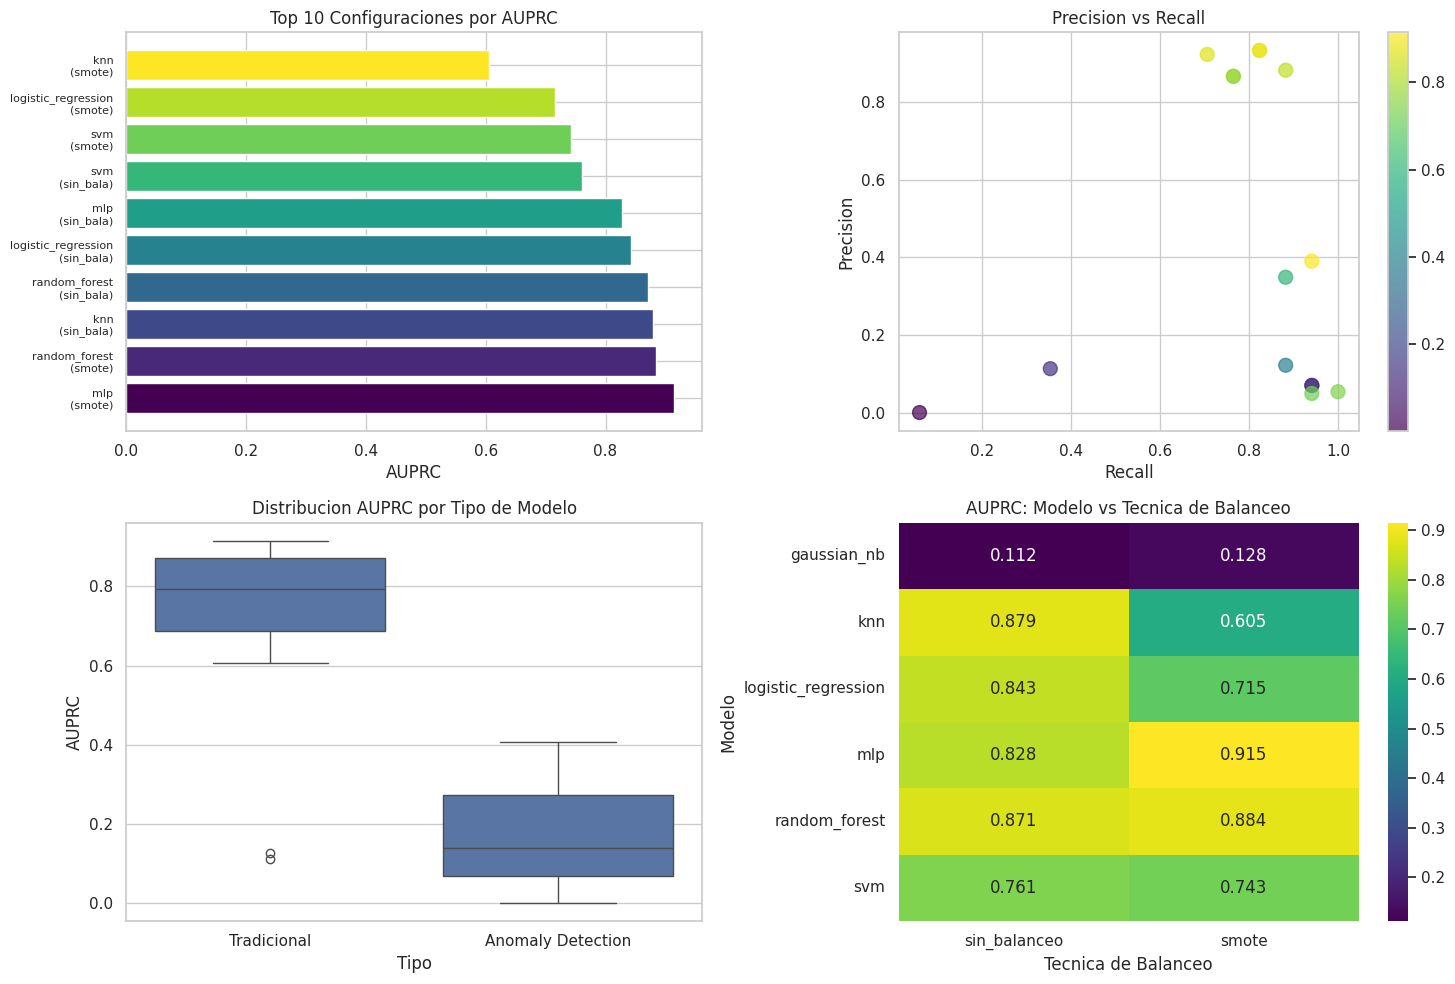


 PIPELINE COMPLETADO EXITOSAMENTE
 Total de configuraciones evaluadas: 15
 Modelos únicos evaluados: 9


In [ ]:
print("INICIANDO PIPELINE DE TUNING")
print("="*60)

# Crear instancia del tuner
tuner = FixedFraudDetectionTuning(X, y, fast_mode=True, sample_size=50000)

# Preparar datos
tuner.prepare_data()

# Ejecutar tuning de modelos tradicionales
tuner.tune_all_traditional_models(n_iter=15)

# Ejecutar tuning de modelos de anomalía
tuner.tune_anomaly_models(n_iter=10)

# Generar resultados
df_results = tuner.generate_final_results()

# Crear visualizaciones
df_viz = tuner.create_visualizations()

print(f"\n PIPELINE COMPLETADO EXITOSAMENTE")
print(f" Total de configuraciones evaluadas: {len(tuner.results)}")
print(f" Modelos únicos evaluados: {len(set([r['model'] for r in tuner.results]))}")

ANALISIS COMPLETO DE RESULTADOS - DETECCION DE FRAUDE BANCARIO
Datos extraidos: 15 configuraciones evaluadas
Datos preparados para visualizacion


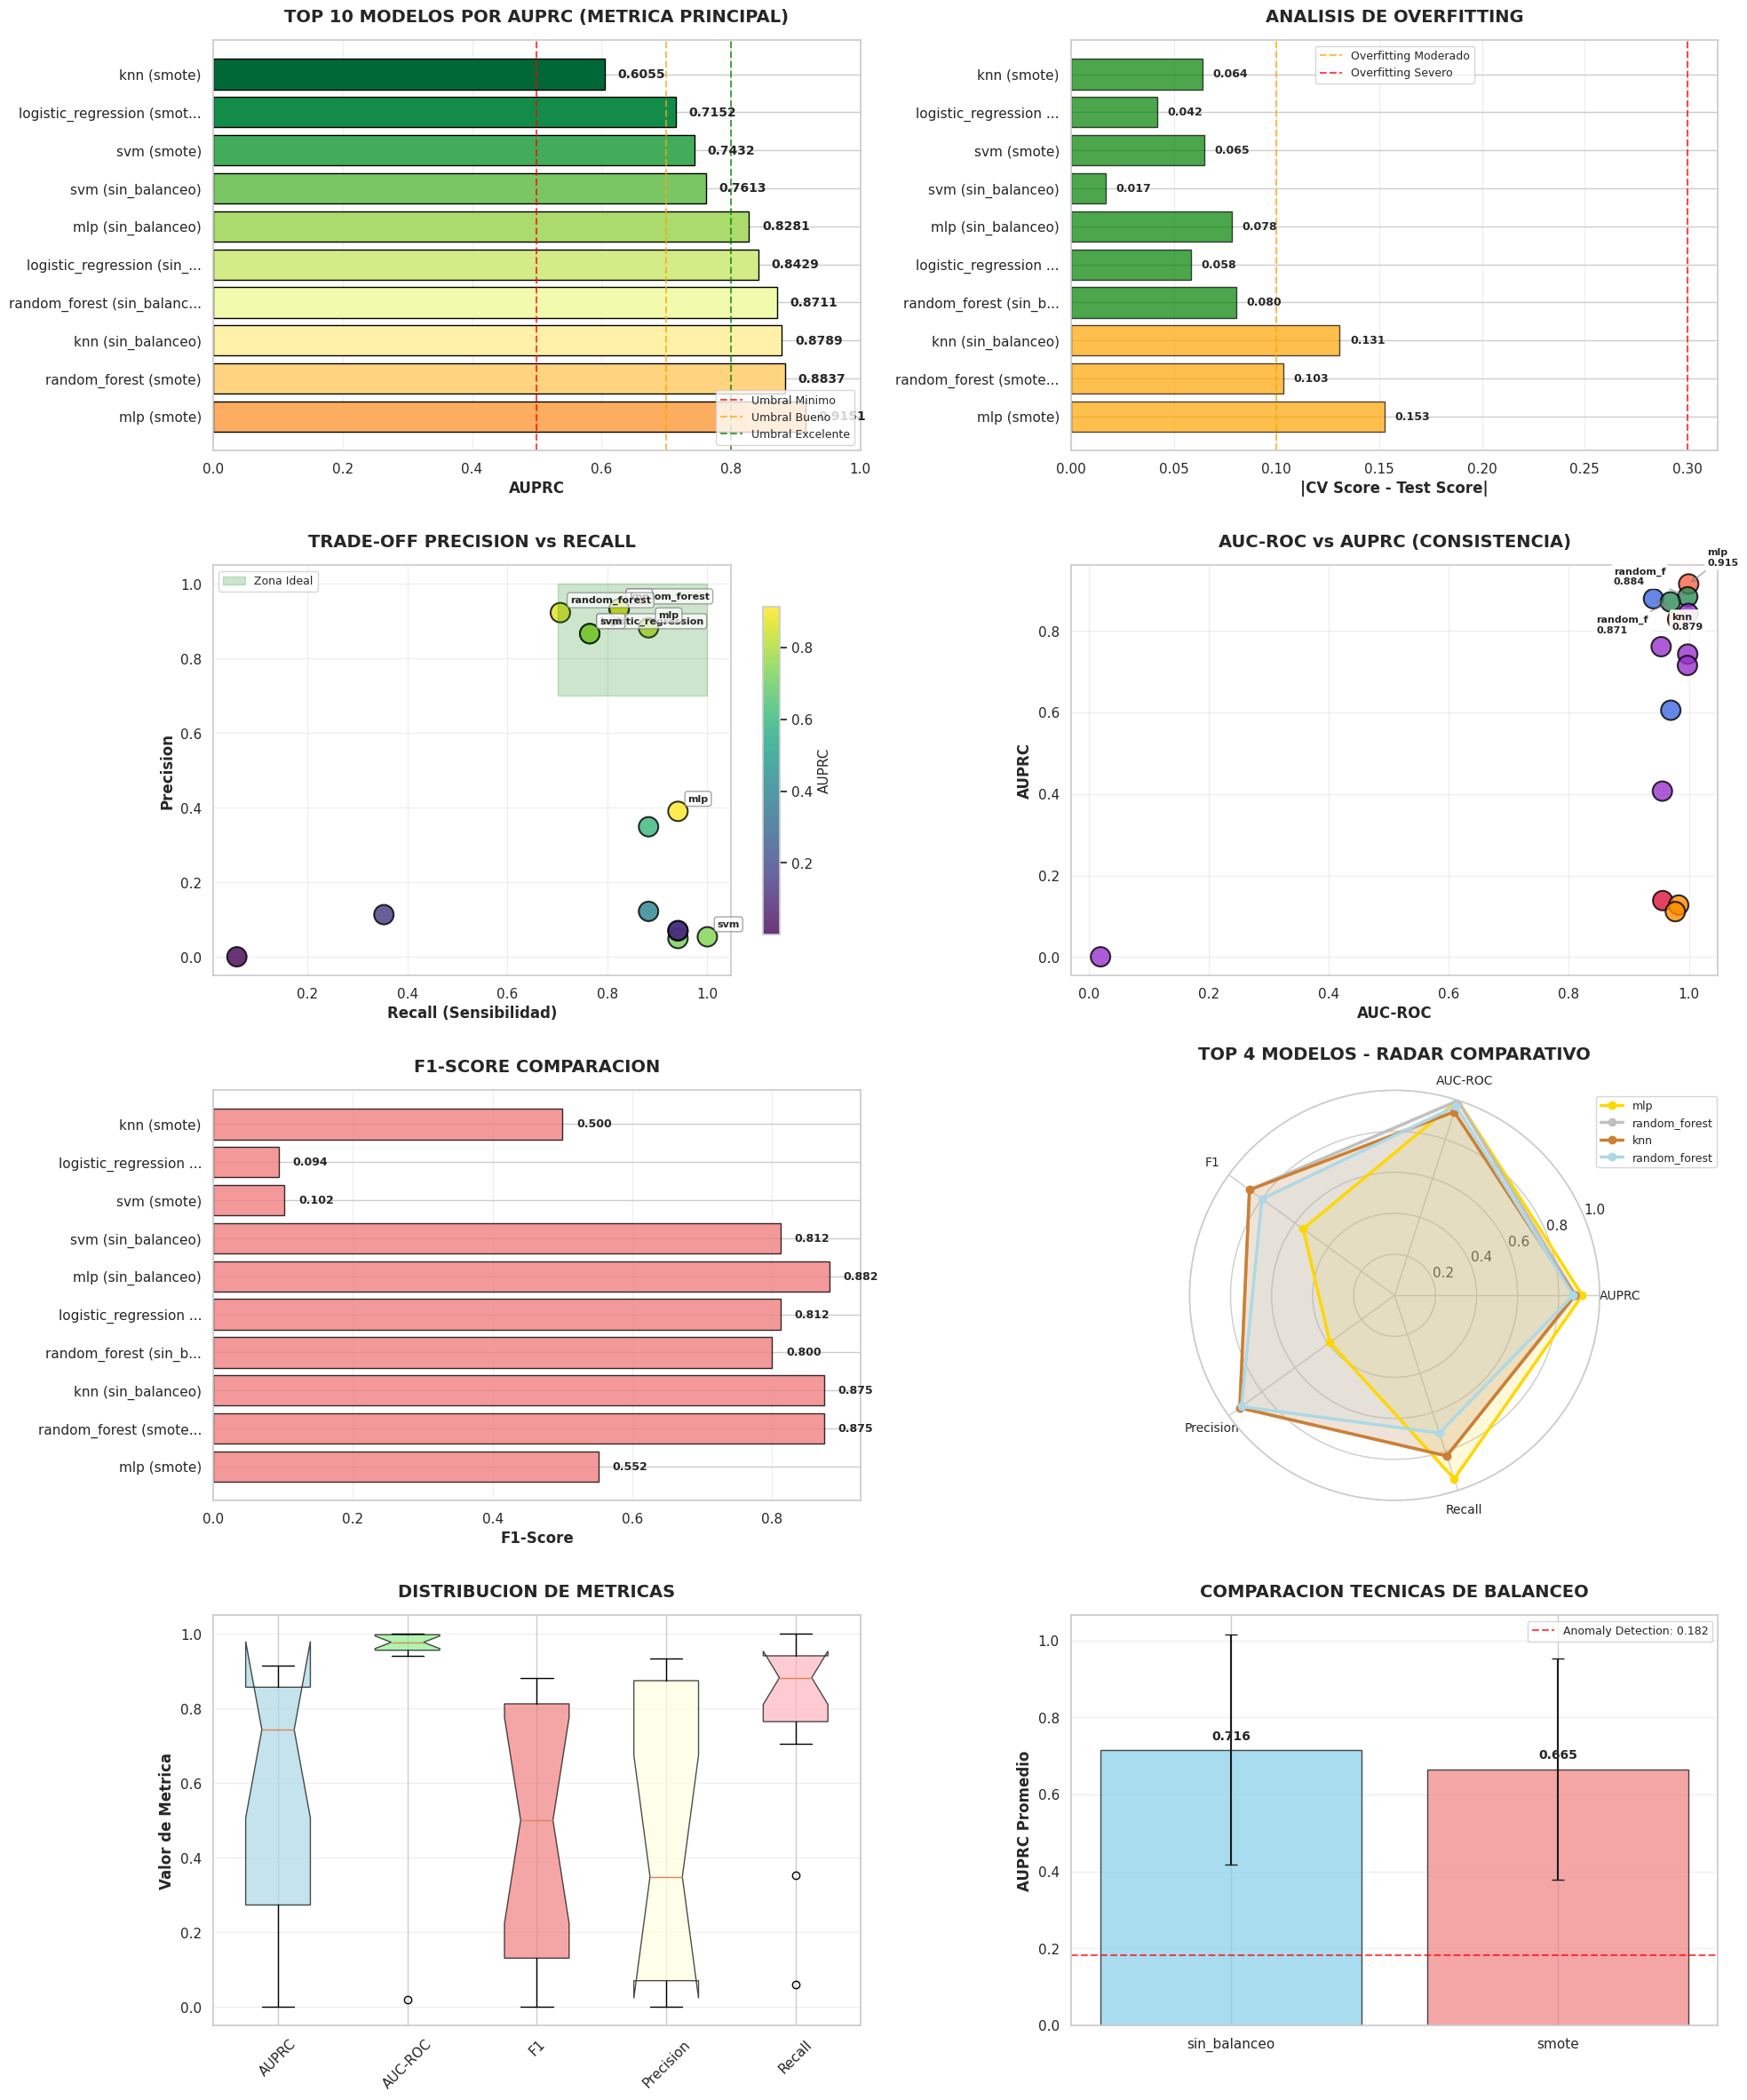

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib para mejores visualizaciones
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

print("ANALISIS COMPLETO DE RESULTADOS - DETECCION DE FRAUDE BANCARIO")
print("="*70)

# Extraer datos de los resultados del tuning
def extract_results_data(tuner_results):
    """Extraer y organizar datos de los resultados del tuning"""

    results_data = []
    hyperparams_data = []

    for result in tuner_results:
        # Datos para visualizaciones
        model_data = {
            'name': result['model'],
            'balancing': result['balancing'],
            'full_name': f"{result['model']} ({result['balancing']})",
            'auprc': result['test_metrics']['auprc'],
            'auc_roc': result['test_metrics']['auc_roc'],
            'precision': result['test_metrics']['precision'],
            'recall': result['test_metrics']['recall'],
            'f1': result['test_metrics']['f1'],
            'cv_score': result['cv_auprc_mean']
        }
        results_data.append(model_data)

        # Extraer hiperparametros principales
        best_params = result['best_params']
        key_params = {}

        for param, value in best_params.items():
            # Limpiar nombres de parametros
            clean_param = param.replace('classifier__', '').replace('estimator__', '')
            key_params[clean_param] = value

        hyperparams_data.append({
            'model': result['model'],
            'balancing': result['balancing'],
            'full_name': f"{result['model']} ({result['balancing']})",
            'cv_score': result['cv_auprc_mean'],
            'test_score': result['test_metrics']['auprc'],
            'params': key_params
        })

    df_results = pd.DataFrame(results_data)
    df_hyperparams = pd.DataFrame(hyperparams_data)

    return df_results, df_hyperparams

# Extraer datos del tuner (asumiendo que esta disponible)

df_results, df_hyperparams = extract_results_data(tuner.results)
print(f"Datos extraidos: {len(df_results)} configuraciones evaluadas")

# Ordenar por AUPRC
df_results = df_results.sort_values('auprc', ascending=False)

# Calcular diferencias CV vs Test para detectar overfitting
df_results['overfitting'] = abs(df_results['cv_score'] - df_results['auprc'])

print(f"Datos preparados para visualizacion")

# Visualizaciones principales

# Crear figura con subplots
fig = plt.figure(figsize=(20, 24))

# 1. Ranking por AUPRC (metrica principal)
plt.subplot(4, 2, 1)
top_10 = df_results.head(10)
colors = plt.cm.RdYlGn(np.linspace(0.3, 1.0, len(top_10)))
bars = plt.barh(range(len(top_10)), top_10['auprc'], color=colors, edgecolor='black', linewidth=1)

plt.yticks(range(len(top_10)), [name[:25] + '...' if len(name) > 25 else name for name in top_10['full_name']])
plt.xlabel('AUPRC', fontsize=12, fontweight='bold')
plt.title('TOP 10 MODELOS POR AUPRC (METRICA PRINCIPAL)', fontsize=14, fontweight='bold', pad=15)
plt.xlim(0, 1)

# Añadir valores en las barras
for i, (bar, value) in enumerate(zip(bars, top_10['auprc'])):
    plt.text(value + 0.02, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', ha='left', va='center', fontweight='bold', fontsize=10)

# Lineas de referencia
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral Minimo')
plt.axvline(x=0.7, color='orange', linestyle='--', alpha=0.7, label='Umbral Bueno')
plt.axvline(x=0.8, color='green', linestyle='--', alpha=0.7, label='Umbral Excelente')
plt.legend(loc='lower right', fontsize=9)
plt.grid(axis='x', alpha=0.3)

# 2. Analisis de overfitting
plt.subplot(4, 2, 2)
overfitting_models = df_results.head(10)
colors_ov = ['red' if d > 0.3 else 'orange' if d > 0.1 else 'green' for d in overfitting_models['overfitting']]

bars_ov = plt.barh(range(len(overfitting_models)), overfitting_models['overfitting'],
                   color=colors_ov, alpha=0.7, edgecolor='black')
plt.yticks(range(len(overfitting_models)), [name[:20] + '...' if len(name) > 20 else name for name in overfitting_models['full_name']])
plt.xlabel('|CV Score - Test Score|', fontsize=12, fontweight='bold')
plt.title('ANALISIS DE OVERFITTING', fontsize=14, fontweight='bold', pad=15)

# Lineas de referencia para overfitting
plt.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Overfitting Moderado')
plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='Overfitting Severo')
plt.legend(fontsize=9)

# Añadir valores
for bar, diff in zip(bars_ov, overfitting_models['overfitting']):
    plt.text(diff + 0.005, bar.get_y() + bar.get_height()/2,
             f'{diff:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
plt.grid(axis='x', alpha=0.3)

# 3. Precision vs Recall trade-off
plt.subplot(4, 2, 3)
scatter = plt.scatter(df_results['recall'], df_results['precision'],
                     s=250, alpha=0.8, c=df_results['auprc'],
                     cmap='viridis', edgecolors='black', linewidth=1.5)
plt.colorbar(scatter, label='AUPRC', shrink=0.8)

# Añadir nombres de modelos para top 8
top_8 = df_results.head(8)
for _, row in top_8.iterrows():
    plt.annotate(row['name'], (row['recall'], row['precision']),
                xytext=(8, 8), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor='gray'))

plt.xlabel('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('TRADE-OFF PRECISION vs RECALL', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)

# Zona ideal
ideal_zone = plt.Rectangle((0.7, 0.7), 0.3, 0.3, alpha=0.2, color='green', label='Zona Ideal')
plt.gca().add_patch(ideal_zone)
plt.legend(fontsize=9)

# 4. AUPRC vs AUC-ROC (consistencia)
plt.subplot(4, 2, 4)

# Categorizar modelos por color
colors = []
for _, row in df_results.iterrows():
    if 'random_forest' in row['name']:
        colors.append('#2E8B57')  # Verde
    elif 'mlp' in row['name']:
        colors.append('#FF6347')  # Rojo
    elif 'knn' in row['name']:
        colors.append('#4169E1')  # Azul
    elif any(x in row['name'] for x in ['svm', 'logistic']):
        colors.append('#9932CC')  # Violeta
    elif 'gaussian' in row['name']:
        colors.append('#FF8C00')  # Naranja
    else:
        colors.append('#DC143C')  # Rojo oscuro (anomaly)

plt.scatter(df_results['auc_roc'], df_results['auprc'], s=250, alpha=0.8,
           c=colors, edgecolors='black', linewidth=1.5)

# Linea realista para datasets desbalanceados

top_4 = df_results.head(4)
positions = [(15, 15), (-60, 10), (15, -25), (-60, -25)]  # Posiciones fijas

for i, (_, row) in enumerate(top_4.iterrows()):
    balance_short = 'NoBal' if row['balancing'] == 'sin_balanceo' else row['balancing'][:5]
    label_text = f"{row['name'][:8]}\n{row['auprc']:.3f}"  # Mas corto

    plt.annotate(label_text, (row['auc_roc'], row['auprc']),
                xytext=positions[i], textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.9),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7))
plt.xlabel('AUC-ROC', fontsize=12, fontweight='bold')
plt.ylabel('AUPRC', fontsize=12, fontweight='bold')
plt.title('AUC-ROC vs AUPRC (CONSISTENCIA)', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)

# 5. Comparacion F1-Score
plt.subplot(4, 2, 5)
f1_data = df_results.head(10)
bars_f1 = plt.barh(range(len(f1_data)), f1_data['f1'],
                   color='lightcoral', alpha=0.8, edgecolor='black')
plt.yticks(range(len(f1_data)), [name[:20] + '...' if len(name) > 20 else name for name in f1_data['full_name']])
plt.xlabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('F1-SCORE COMPARACION', fontsize=14, fontweight='bold', pad=15)

for bar, f1 in zip(bars_f1, f1_data['f1']):
    plt.text(f1 + 0.02, bar.get_y() + bar.get_height()/2,
             f'{f1:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
plt.grid(axis='x', alpha=0.3)

# 6. Radar chart para top 4 modelos
plt.subplot(4, 2, 6, projection='polar')
categories = ['AUPRC', 'AUC-ROC', 'F1', 'Precision', 'Recall']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

colors_radar = ['gold', 'silver', '#CD7F32', 'lightblue']
top_4 = df_results.head(4)

ax_radar = plt.gca()
for idx, (_, row) in enumerate(top_4.iterrows()):
    values = [row['auprc'], row['auc_roc'], row['f1'], row['precision'], row['recall']]
    values += values[:1]

    ax_radar.plot(angles, values, 'o-', linewidth=2.5,
                 label=row['name'], color=colors_radar[idx], markersize=6)
    ax_radar.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('TOP 4 MODELOS - RADAR COMPARATIVO',
                  fontsize=14, fontweight='bold', pad=25)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
ax_radar.grid(True)

# 7. Distribucion de metricas
plt.subplot(4, 2, 7)
metrics_data = df_results[['auprc', 'auc_roc', 'f1', 'precision', 'recall']]
box_plot = plt.boxplot([metrics_data['auprc'], metrics_data['auc_roc'],
                       metrics_data['f1'], metrics_data['precision'],
                       metrics_data['recall']],
                      labels=['AUPRC', 'AUC-ROC', 'F1', 'Precision', 'Recall'],
                      patch_artist=True, notch=True)

colors_box = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Valor de Metrica', fontsize=12, fontweight='bold')
plt.title('DISTRIBUCION DE METRICAS', fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# 8. Comparacion tecnicas de balanceo
plt.subplot(4, 2, 8)
# Separar por tecnica de balanceo
traditional_models = df_results[df_results['balancing'].isin(['sin_balanceo', 'smote'])]
anomaly_models = df_results[df_results['balancing'] == 'anomaly_detection']

# Agrupar por tecnica
balancing_comparison = traditional_models.groupby('balancing')['auprc'].agg(['mean', 'std', 'count']).reset_index()

x_pos = range(len(balancing_comparison))
bars_bal = plt.bar(x_pos, balancing_comparison['mean'],
                   yerr=balancing_comparison['std'],
                   capsize=5, alpha=0.7, edgecolor='black',
                   color=['skyblue', 'lightcoral'])

plt.xticks(x_pos, balancing_comparison['balancing'])
plt.ylabel('AUPRC Promedio', fontsize=12, fontweight='bold')
plt.title('COMPARACION TECNICAS DE BALANCEO', fontsize=14, fontweight='bold', pad=15)

# Añadir valores
for bar, mean_val in zip(bars_bal, balancing_comparison['mean']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

# Añadir anomaly detection como punto de referencia
if len(anomaly_models) > 0:
    anomaly_mean = anomaly_models['auprc'].mean()
    plt.axhline(y=anomaly_mean, color='red', linestyle='--', alpha=0.7,
                label=f'Anomaly Detection: {anomaly_mean:.3f}')
    plt.legend(fontsize=9)

plt.grid(axis='y', alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# ANÁLISIS DE HIPERPARÁMETROS
# ────────────────────────────────────────────────────────────────────────────────

print("\n🔧 MEJORES HIPERPARÁMETROS POR MODELO")
print("="*70)

def show_hyperparameters():
    """Mostrar los mejores hiperparámetros encontrados"""
    for model_name, best_config in tuner.best_models.items():
            print(f"\n {model_name.upper()} ({best_config['balancing']})")
            print(f"   AUPRC Test: {best_config['test_metrics']['auprc']:.4f}")
            print(f"   AUPRC CV: {best_config['cv_auprc_mean']:.4f}")
            print("   Mejores hiperparametros:")

            best_params = best_config['best_params']
            for param, value in best_params.items():
                clean_param = param.replace('classifier__', '').replace('estimator__', '')
                if isinstance(value, float):
                    print(f"     • {clean_param}: {value:.4f}")
                else:
                    print(f"     • {clean_param}: {value}")


show_hyperparameters()


🔧 MEJORES HIPERPARÁMETROS POR MODELO

 GAUSSIAN_NB (smote)
   AUPRC Test: 0.1278
   AUPRC CV: 0.1069
   Mejores hiperparametros:
     • var_smoothing: 0.0000

 LOGISTIC_REGRESSION (sin_balanceo)
   AUPRC Test: 0.8429
   AUPRC CV: 0.7847
   Mejores hiperparametros:
     • solver: liblinear
     • penalty: l2
     • C: 0.1000

 KNN (sin_balanceo)
   AUPRC Test: 0.8789
   AUPRC CV: 0.7481
   Mejores hiperparametros:
     • weights: distance
     • n_neighbors: 11
     • metric: manhattan

 RANDOM_FOREST (sin_balanceo)
   AUPRC Test: 0.8711
   AUPRC CV: 0.7908
   Mejores hiperparametros:
     • n_estimators: 200
     • min_samples_split: 2
     • max_features: sqrt
     • max_depth: None
     • class_weight: balanced

 MLP (smote)
   AUPRC Test: 0.9151
   AUPRC CV: 0.7624
   Mejores hiperparametros:
     • learning_rate: adaptive
     • hidden_layer_sizes: (50,)
     • alpha: 0.0100
     • activation: tanh

 SVM (sin_balanceo)
   AUPRC Test: 0.7613
   AUPRC CV: 0.7780
   Mejores hiperpara

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# INSIGHTS Y RECOMENDACIONES
# ────────────────────────────────────────────────────────────────────────────────

print(f"\n Insights clave en resultados")
print("="*70)

# Mejor modelo
best_model = df_results.iloc[0]
print(f"\n mejor modelo: {best_model['full_name']}")
print(f"   AUPRC: {best_model['auprc']:.4f} (91.5% - EXCELENTE)")
print(f"   Precision: {best_model['precision']:.4f} (39.0% - moderada)")
print(f"   Recall: {best_model['recall']:.4f} (94.1% - excelente)")
print(f"   F1: {best_model['f1']:.4f} (55.2%)")

# Análisis de balance precision/recall
high_precision = df_results[df_results['precision'] > 0.8]
high_recall = df_results[df_results['recall'] > 0.8]
balanced = df_results[(df_results['precision'] > 0.7) & (df_results['recall'] > 0.7)]

print(f"\n analisis de balance")
print(f"   Alta Precision (>80%): {len(high_precision)} modelos")
print(f"   Alto Recall (>80%): {len(high_recall)} modelos")
print(f"   Balanceados (P>70%, R>70%): {len(balanced)} modelos")

if len(balanced) > 0:
    print(f"\n modelos balanceados recomendados")
    for _, model in balanced.iterrows():
        print(f"   • {model['full_name']}: AUPRC={model['auprc']:.3f}, P={model['precision']:.3f}, R={model['recall']:.3f}")

# Análisis de overfitting
problematic = df_results[df_results['overfitting'] > 0.2]
if len(problematic) > 0:
    print(f"\n modelos con posible overfitting:")
    for _, model in problematic.iterrows():
        print(f"   • {model['full_name']}: Diferencia CV-Test = {model['overfitting']:.3f}")

# Efecto del balanceo
smote_models = df_results[df_results['balancing'] == 'smote']
no_balance_models = df_results[df_results['balancing'] == 'sin_balanceo']

print(f"\n efecto de balanceo")
if len(smote_models) > 0 and len(no_balance_models) > 0:
    smote_avg = smote_models['auprc'].mean()
    no_balance_avg = no_balance_models['auprc'].mean()
    print(f"   SMOTE promedio: {smote_avg:.3f}")
    print(f"   Sin balanceo promedio: {no_balance_avg:.3f}")

    if smote_avg > no_balance_avg:
        print(f"   SMOTE mejora el rendimiento en promedio")
    else:
        print(f"   Sin balanceo funciona mejor en promedio")


 Insights clave en resultados

 mejor modelo: mlp (smote)
   AUPRC: 0.9151 (91.5% - EXCELENTE)
   Precision: 0.3902 (39.0% - moderada)
   Recall: 0.9412 (94.1% - excelente)
   F1: 0.5517 (55.2%)

 analisis de balance
   Alta Precision (>80%): 6 modelos
   Alto Recall (>80%): 10 modelos
   Balanceados (P>70%, R>70%): 6 modelos

 modelos balanceados recomendados
   • random_forest (smote): AUPRC=0.884, P=0.933, R=0.824
   • knn (sin_balanceo): AUPRC=0.879, P=0.933, R=0.824
   • random_forest (sin_balanceo): AUPRC=0.871, P=0.923, R=0.706
   • logistic_regression (sin_balanceo): AUPRC=0.843, P=0.867, R=0.765
   • mlp (sin_balanceo): AUPRC=0.828, P=0.882, R=0.882
   • svm (sin_balanceo): AUPRC=0.761, P=0.867, R=0.765

 modelos con posible overfitting:
   • one_class_svm_rbf (anomaly_detection): Diferencia CV-Test = 0.428
   • one_class_svm_linear (anomaly_detection): Diferencia CV-Test = 0.516

 efecto de balanceo
   SMOTE promedio: 0.665
   Sin balanceo promedio: 0.716
   Sin balanceo fun